In [2]:
from folium.plugins import HeatMap
from folium.plugins import BeautifyIcon
from branca.colormap import linear
from branca.element import Template, MacroElement
from selenium import webdriver
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
import pandas as pd
import duckdb
import folium
import os
import random
import geopandas as gpd

from matplotlib import font_manager

# 設置支持中文的字體，這裡以 "SimHei" 為例，你也可以選擇其他支持中文的字體
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 正常顯示負號

pd.set_option('display.max_columns', None)

conn = duckdb.connect(database='warehouse\data_sandbox.duckdb')
sna_loc = conn.execute("SELECT distinct sna, latitude as lat,longitude as lng FROM youbike").fetch_df()
conn.close()

gdf = gpd.read_file('warehouse\週末起訖站點統計_202307.geojson')

def get_lat_lon(df,from_stop,to_stop):
    return df.merge(sna_loc, left_on=f"{from_stop}", right_on="sna")\
    .rename(columns={"lat":"lat_start","lng":"lng_start"})\
    .drop(columns="sna")\
    .merge(sna_loc, left_on=f"{to_stop}", right_on="sna")\
    .rename(columns={"lat":"lat_end","lng":"lng_end"})\
    .drop(columns="sna")

##### 變化率GIF圖

In [3]:
conn = duckdb.connect(database='warehouse\data_sandbox.duckdb')
df = conn.execute("SELECT * FROM youbike").fetch_df()
conn.close()

df = df[['sno', 'sna', 'sarea','fetch_time','latitude', 'longitude','available_rent_bikes','total','temperature','description']].sort_values(['sno','fetch_time'], ascending=True)
df["fetch_time"] = pd.to_datetime(df["fetch_time"])

# 定義計算變化率的函數
def calculate_change_rate(group):
    # 計算 available_rent_bikes 的變化率
    group['change_rate'] = group['available_rent_bikes'].pct_change().fillna(0)
    
    # 計算 fetch_time 的時間差（以分鐘計算）
    group['time_diff'] = group['fetch_time'].diff().dt.total_seconds() / 60
    
    # 如果時間差超過 20 分鐘，變化率設為 0
    group.loc[group['time_diff'] > 12, 'change_rate'] = 0
    
    return group

df_pct = df.groupby('sno',as_index=False).apply(calculate_change_rate)
df_available = df_pct.query("~time_diff.isna()").query("time_diff <12").query("change_rate != inf")

def generate_html(df, threshold=0.1):
    if os.path.exists(rf"D:\\sandbox_git\\warehouse\\bike_html\\bike_change_rate_map_{df.fetch_time.unique()[0].strftime('%Y%m%d%H%M')}.html"):
        print("exists")
        pass
    else:
        # Create a base map
        m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=13, tiles='CartoDB positron')

        # Normalize change_rate to a range between 0 and 1 for color mapping
        min_change_rate = df['change_rate'].min()
        max_change_rate = df['change_rate'].max()
        df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
        df['norm_change_rate'] = df['norm_change_rate'].fillna(0)
        
        # Create a custom colormap
        colormap = linear.RdYlBu_11.scale(min_change_rate, max_change_rate)  # Red for high, blue for low
        colormap = colormap.to_step(n=10)  # Discretize the color map into 10 steps
        
        # Add points to the map
        for i, row in df.iterrows():
            # 如果 change_rate 絕對值小於 threshold，顯示為灰色
            if abs(row['change_rate']) < threshold:
                color = 'grey'
                fill_opacity = 0.01
                radius=1
            else:
                color = colormap(row['change_rate'])
                fill_opacity = 0.4
                radius=6
            
            folium.CircleMarker(
                location=(row['latitude'], row['longitude']),
                radius=radius, 
                color=color,  
                fill=True,
                fill_opacity=fill_opacity,
                popup=f"Change Rate: {row['change_rate']}"
            ).add_to(m)

        # Add the colormap legend
        colormap.add_to(m)

        # 添加顯示 fetch_time 的文字
        timestamp = df.fetch_time.unique()[0].strftime('%Y-%m-%d %H:%M:%S')
        print(timestamp)
        
        # 自定義的 HTML 模板，將時間顯示在右下角
        template = """
        {% macro html(this, kwargs) %}
        <div style="position: fixed;
                    bottom: 750px; right: 50px; z-index: 9999;
                    background-color: black; padding: 5px;
                    font-size: 24px; color: white">
        Fetched at: """ + timestamp + """
        </div>
        {% endmacro %}
        """
        
        # 添加模板到地圖
        macro = MacroElement()
        macro._template = Template(template)
        m.get_root().add_child(macro)

        # Save the map
        m.save(f"D:\\sandbox_git\\warehouse\\bike_html\\bike_change_rate_map_{df.fetch_time.unique()[0].strftime('%Y%m%d%H%M')}.html")

for time in df_available.fetch_time.unique():
    df = df_available.query("fetch_time == @time")
    generate_html(df)

# Set up the Selenium driver (ensure you have the correct driver installed)
options = webdriver.ChromeOptions()
options.add_argument('headless')
driver = webdriver.Chrome(options=options)

# Folder paths
html_folder = 'D:/sandbox_git/warehouse/bike_html'
output_folder = 'D:/sandbox_git/warehouse/bike_images'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Convert each HTML file to an image
for file_name in os.listdir(html_folder):
    if file_name.endswith('.html'):
        file_path = os.path.join(html_folder, file_name)
        output_image_path = os.path.join(output_folder, file_name.replace('.html', '.png'))

        driver.get(f'file:///{file_path}')
        driver.set_window_size(1080, 1080)  # Adjust the window size as needed
        driver.save_screenshot(output_image_path)

driver.quit()

# Folder where images are saved
image_folder = 'D:/sandbox_git/warehouse/bike_images'
output_gif = 'D:/sandbox_git/warehouse/bike_change_rate_map.gif'

# Get all the images
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.png')]
image_files.sort()  # Ensure correct order

# Open images and create a GIF
images = [Image.open(img_file) for img_file in image_files]
images[0].save(output_gif, save_all=True, append_images=images[1:], duration=90, loop=0)

C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_pct = df.groupby('sno',as_index=False).apply(calculate_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.

2024-09-29 14:30:00


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 14:40:03


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 14:50:04


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 15:00:06


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 15:10:07


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 15:20:04


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 15:30:03


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 15:40:03


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 15:50:04


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 16:00:03


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 16:10:03


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 16:20:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 16:30:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 16:40:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 16:50:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 17:00:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 17:10:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 17:20:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 17:30:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 17:40:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 18:00:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 18:20:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 18:30:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 18:40:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 18:50:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 19:00:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 19:10:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 19:20:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 19:30:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 19:40:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 19:50:04


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 20:00:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 20:10:03


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 20:20:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 20:40:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 20:50:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 21:10:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 21:20:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 21:30:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 21:40:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 21:50:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 22:20:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 22:40:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 22:50:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 23:00:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 23:20:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 23:30:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 23:50:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 00:00:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 00:10:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 00:20:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 00:30:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 00:40:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 00:50:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 01:00:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 01:10:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 01:20:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 01:30:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 01:40:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 01:50:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 02:00:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 02:10:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 02:20:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 03:00:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 03:10:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 03:20:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 12:10:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 12:20:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 12:30:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 12:40:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 12:50:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 13:00:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 13:10:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 13:20:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 13:30:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 13:40:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 13:50:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 14:40:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 14:50:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 15:00:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 15:10:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 15:20:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 15:30:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 15:40:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 16:00:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 16:10:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 16:20:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 16:30:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 16:40:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 16:50:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 17:00:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 17:10:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 17:20:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 17:30:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 17:40:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 17:50:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 18:00:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 18:10:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 18:20:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 18:30:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 18:40:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 18:50:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 19:00:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 19:10:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 19:20:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 19:30:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 19:40:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 19:50:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 20:00:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 20:10:03


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 20:20:03


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 20:30:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 20:40:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 20:50:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 21:00:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 21:10:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 21:20:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 21:30:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 21:40:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 21:50:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 22:00:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 22:10:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 22:20:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 22:30:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 22:40:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 22:50:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 23:00:03


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 23:10:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 23:20:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 23:30:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 23:40:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 23:50:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 00:00:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 00:10:03


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 00:20:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 00:30:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 00:40:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 00:50:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 01:00:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 01:10:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 01:20:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 01:30:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 01:40:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 01:50:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 02:00:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 02:10:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 02:20:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 02:30:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 02:40:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 02:50:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 03:00:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 03:10:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 03:20:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 15:40:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 17:50:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 18:00:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 18:10:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 18:20:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 18:30:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 18:40:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 18:50:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 19:00:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 19:10:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 19:20:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 19:30:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 19:40:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 19:50:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 20:00:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 20:10:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 20:20:03


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 20:30:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 20:40:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 20:50:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 21:00:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 21:10:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 21:20:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 21:30:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-10-01 21:40:02


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 17:50:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 18:10:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 20:30:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 21:00:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 23:10:03


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 23:40:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-30 12:00:01


C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_20092\3990349628.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_change_rate'] = df['norm_change_rate'].fillna(0)


2024-09-29 22:30:01


##### 週末起訖站點

In [12]:
# 讀取 GeoJSON 檔案
gdf = gpd.read_file('warehouse\週間起訖站點統計_202307.geojson')\
        .sort_values(by=["on_stop_id","off_stop_id"])\
            .reset_index()\
                .drop(columns="index")

gdf['route'] = gdf.apply(lambda row: tuple(sorted([row['on_stop_id'], row['off_stop_id']])), axis=1)

In [18]:
gpd.GeoDataFrame(gdf[["sum_of_txn_times","width","geometry"]], geometry='geometry')\
    .to_file(r"D:\sandbox_git\project\map_application\static\geojson\week_route.geojson", driver="GeoJSON")

In [26]:
gdf.sort_values("sum_of_txn_times",ascending=False).head(100)

,on_stop_id,off_stop_id,on_stop,off_stop,sum_of_txn_times,district_origin,district_destination,width,geometry,route
6745,U101025,U101022,臺灣科技大學側門,捷運公館站(2號出口),3328,大安區,大安區,15.000000,"LINESTRING (121.53973 25.01295, 121.53438 25.0...","(U101022, U101025)"
7366,U101027,U101022,臺灣科技大學後門,捷運公館站(2號出口),2958,大安區,大安區,13.443042,"LINESTRING (121.54165 25.01182, 121.53438 25.0...","(U101022, U101027)"
215169,U112010,U112011,捷運象山站(2號出口),象山公園,2929,信義區,信義區,13.321010,"LINESTRING (121.56974 25.03222, 121.56981 25.0...","(U112010, U112011)"
5912,U101022,U101025,捷運公館站(2號出口),臺灣科技大學側門,2911,大安區,大安區,13.245266,"LINESTRING (121.53438 25.01491, 121.53973 25.0...","(U101022, U101025)"
70019,U104004,U104030,百齡國小,捷運劍潭站(2號出口),2618,士林區,士林區,12.012323,"LINESTRING (121.51918 25.08521, 121.52455 25.0...","(U104004, U104030)"
...,...,...,...,...,...,...,...,...,...,...
93580,U106010,U106006,紀州庵,捷運古亭站(2號出口),975,中正區,中正區,5.098587,"LINESTRING (121.52049 25.02092, 121.52346 25.0...","(U106006, U106010)"
76477,U104072,U104108,芝山國小,捷運芝山站(2號出口)_1,972,士林區,士林區,5.085963,"LINESTRING (121.53595 25.11044, 121.52263 25.1...","(U104072, U104108)"
36970,U101167,U112022,捷運國父紀念館站(2號出口),三張犁,972,大安區,信義區,5.085963,"LINESTRING (121.55745 25.04122, 121.55760 25.0...","(U101167, U112022)"
16545,U101110,U101109,捷運古亭站(6號出口),臺灣師範大學(圖書館),968,大安區,大安區,5.069131,"LINESTRING (121.52217 25.02760, 121.52973 25.0...","(U101109, U101110)"


In [4]:
results = gdf.sort_values(by=["on_stop_id","off_stop_id"])\
    .groupby("route",as_index=False)\
    .agg(mean_of_txn_times_byRoutes=("sum_of_txn_times","mean"))\
    .merge(gdf[["on_stop_id","off_stop_id","on_stop","off_stop","route","geometry"]].drop_duplicates(subset="route"), on="route",validate="1:1")

results["route_pct"] = (results["mean_of_txn_times_byRoutes"] / results["mean_of_txn_times_byRoutes"].sum()) *100

In [55]:
results.sort_values("mean_of_txn_times_byRoutes",ascending=False)

,route,mean_of_txn_times_byRoutes,on_stop_id,off_stop_id,on_stop,off_stop,geometry,route_pct
7048,"(U101022, U101025)",3119.5,U101022,U101025,捷運公館站(2號出口),臺灣科技大學側門,"LINESTRING (121.53438 25.01491, 121.53973 25.0...",0.191093
7050,"(U101022, U101027)",2719.5,U101022,U101027,捷運公館站(2號出口),臺灣科技大學後門,"LINESTRING (121.53438 25.01491, 121.54165 25.0...",0.166590
169091,"(U112010, U112011)",2711.5,U112010,U112011,捷運象山站(2號出口),象山公園,"LINESTRING (121.56974 25.03222, 121.56981 25.0...",0.166100
74399,"(U104004, U104030)",2579.5,U104004,U104030,百齡國小,捷運劍潭站(2號出口),"LINESTRING (121.51918 25.08521, 121.52455 25.0...",0.158014
116675,"(U107008, U107010)",2372.5,U107008,U107010,捷運劍南路站(2號出口),樂群二敬業四路口,"LINESTRING (121.55535 25.08401, 121.55813 25.0...",0.145334
...,...,...,...,...,...,...,...,...
61115,"(U103019, U104107)",1.0,U104107,U103019,捷運士林站(1號出口),民權延平路口(西北側),"LINESTRING (121.52552 25.09561, 121.51099 25.0...",0.000061
61116,"(U103019, U104111)",1.0,U103019,U104111,民權延平路口(西北側),士商路40巷口,"LINESTRING (121.51099 25.06326, 121.52054 25.0...",0.000061
61117,"(U103019, U105001)",1.0,U103019,U105001,民權延平路口(西北側),台北花木批發市場,"LINESTRING (121.51099 25.06326, 121.54074 25.0...",0.000061
123653,"(U107038, U110047)",1.0,U110047,U107038,捷運小巨蛋站(5號出口),捷運中山國小站(4號出口),"LINESTRING (121.55352 25.05176, 121.52697 25.0...",0.000061


In [56]:
get_lat_lon(results,"on_stop","off_stop")

,route,mean_of_txn_times_byRoutes,on_stop_id,off_stop_id,on_stop,off_stop,geometry,route_pct,lat_start,lng_start,lat_end,lng_end
0,"(U101001, U101001)",332.0,U101001,U101001,捷運科技大樓站,捷運科技大樓站,"LINESTRING (121.54360 25.02605, 121.54360 25.0...",0.020338,25.026051,121.543602,25.026051,121.543602
1,"(U101001, U101002)",87.0,U101001,U101002,捷運科技大樓站,復興南路二段273號前,"LINESTRING (121.54360 25.02605, 121.54357 25.0...",0.005329,25.026051,121.543602,25.025650,121.543571
2,"(U101001, U101003)",147.0,U101001,U101003,捷運科技大樓站,國北教大實小東側門,"LINESTRING (121.54360 25.02605, 121.54124 25.0...",0.009005,25.026051,121.543602,25.024290,121.541237
3,"(U101001, U101004)",310.5,U101001,U101004,捷運科技大樓站,和平公園東側,"LINESTRING (121.54360 25.02605, 121.54282 25.0...",0.019020,25.026051,121.543602,25.023510,121.542824
4,"(U101001, U101005)",968.0,U101001,U101005,捷運科技大樓站,辛亥復興路口西北側,"LINESTRING (121.54360 25.02605, 121.54299 25.0...",0.059297,25.026051,121.543602,25.021530,121.542992
...,...,...,...,...,...,...,...,...,...,...,...,...
156679,"(U119089, U119090)",29.5,U119089,U119090,臺大獸醫館南側,臺大新體育館東南側,"LINESTRING (121.54242 25.01791, 121.53591 25.0...",0.001807,25.017910,121.542419,25.021120,121.535912
156680,"(U119089, U119091)",3.0,U119089,U119091,臺大獸醫館南側,臺大明達館北側(員工宿舍),"LINESTRING (121.54242 25.01791, 121.54469 25.0...",0.000184,25.017910,121.542419,25.018160,121.544693
156681,"(U119090, U119090)",148.0,U119090,U119090,臺大新體育館東南側,臺大新體育館東南側,"LINESTRING (121.53591 25.02112, 121.53591 25.0...",0.009066,25.021120,121.535912,25.021120,121.535912
156682,"(U119090, U119091)",16.5,U119090,U119091,臺大新體育館東南側,臺大明達館北側(員工宿舍),"LINESTRING (121.53591 25.02112, 121.54469 25.0...",0.001011,25.021120,121.535912,25.018160,121.544693


##### 資料分入行政區

In [7]:
from shapely.geometry import Point

districts = gpd.read_file(r'D:\sandbox_git\project\map_application\static\geojson\OSM_DATA.geojson')

# 假設你有座標點資料 (DataFrame)，包含經緯度
data = get_lat_lon(results,"on_stop","off_stop")

def get_distric(data,lng_start="lng_start",lat_start="lat_start"):
    # 將經緯度轉換為 Point 物件，並放入 GeoDataFrame 中
    geometry = [Point(xy) for xy in zip(data[f'{lng_start}'], data[f'{lat_start}'])]
    geo_data = gpd.GeoDataFrame(data, geometry=geometry)

    # 設定 CRS (坐標參考系統)，這裡假設是 WGS84 (EPSG:4326)
    geo_data.set_crs(epsg=4326, inplace=True)
    districts.set_crs(epsg=4326, inplace=True)

    # 使用 sjoin 進行空間聯接，將每個點對應到行政區
    # 'within' 表示點位於 Polygon 內
    joined_data = gpd.sjoin(geo_data, districts, how='left', op='within')

    # 假設 districts DataFrame 中有一個欄位是 'district_name'，表示行政區名稱
    # 我們會將該欄位加入到點資料中
    geo_data['district_name'] = joined_data['name']

    return geo_data

get_distric(data,"lng_start","lat_start")
# 查看結果，原始的點資料加上對應的行政區名稱
# geo_data.to_csv(r"D:\sandbox_git\warehouse\insight\週末起訖站點統計_cleaned.csv",index=False)

NameError: name 'data' is not defined

In [8]:
import folium

# 創建地圖對象，設置中心點及縮放級別
m = folium.Map(location=[25.03, 121.5], zoom_start=14)

# 使用 style_function 設定每條線的樣式，包括 width
def style_function(feature):
    return {
        'color': 'blue',          # 線條顏色
        'weight': feature['properties']['width'],  # 設定寬度
        'opacity': 0.8            # 透明度
    }

# 將 GeoJSON 數據加入到地圖上，並應用 style_function
folium.GeoJson(gdf.iloc[:900], style_function=style_function).add_to(m)

# 顯示地圖
m

In [ ]:
gdf[["on_stop_id","on_stop"]].drop_duplicates(subset=["on_stop_id"])

In [ ]:
# 創建一個字典來存放每個 on_stop_id 的顏色
on_stop_colors = {}
unique_on_stops = gdf['on_stop_id'].unique()

# 生成隨機顏色對應於每個 on_stop_id
colors = list(mcolors.CSS4_COLORS.values())  # 使用 CSS4 定義的顏色
random.shuffle(colors)  # 隨機打亂顏色列表

for i, on_stop_id in enumerate(unique_on_stops):
    on_stop_colors[on_stop_id] = colors[i % len(colors)]  # 確保顏色不會超出列表範圍

# 設定地圖的初始中心點與縮放級別
center_lat = gdf['geometry'].centroid.y.mean()
center_lon = gdf['geometry'].centroid.x.mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='cartodb positron')

# 遍歷資料並繪製對應的 LINESTRING
for _, row in gdf.iterrows():
    if row['geometry'].geom_type == 'LineString':
        coords = list(row['geometry'].coords)  # 取得 LINESTRING 的經緯度
        locations = [(lat, lon) for lon, lat in coords]  # folium 需要 (緯度, 經度) 的順序
        
        # 根據 on_stop_id 選擇顏色
        line_color = on_stop_colors[row['on_stop_id']]
        
        # 使用 folium 繪製線段，並根據 'width' 設置線條的寬度
        folium.PolyLine(
            locations=locations,
            color=line_color,
            weight=row['width'],  # 使用對應的線寬
            opacity=0.8
        ).add_to(m)

# 保存或顯示地圖
m.save("transit_line_map.html")  # 保存為 HTML 文件
m  # 若在 Jupyter Notebook 或 IPython 中執行，這樣可以直接顯示地圖

##### 需求預測視覺化

In [ ]:
# 假設你的資料存放在 df 中
df = gpd.read_file('D:\sandbox_git\warehouse\未設站區域需求預測_202303.geojson')   

# 建立一個類別對應顏色的字典
category_color_map = {
    '低': 'blue',
    '極低': 'purple',
    '中低': 'green',
    '中': 'orange',
    '高': 'red'
}

# 初始化地圖
fig = go.Figure()

# 遍歷每個類別並繪製對應的 POLYGON
for category, color in category_color_map.items():
    # 過濾資料集只保留該類別的資料
    filtered_df = df[df['category'] == category]
    
    # 繪製每一個 POLYGON
    for _, row in filtered_df.iterrows():
        # 獲取 POLYGON 的邊界座標
        if row['geometry'].geom_type == 'Polygon':
            x, y = row['geometry'].exterior.xy
            # 將 array.array 轉換為 list
            lon = list(x)
            lat = list(y)
            fig.add_trace(go.Scattermapbox(
                fill="toself",
                lon=lon,
                lat=lat,
                mode='lines',
                line=dict(width=2, color=color),
                fillcolor=color,
                name=category
            ))
            
# 設定 Mapbox 底圖樣式和中心位置
fig.update_layout(
    mapbox_style="dark",  # 使用 Mapbox 的 dark-v11 底圖
    mapbox_accesstoken="pk.eyJ1Ijoic2hpYm55IiwiYSI6ImNrcWtjMDg0NjA0anQyb3RnZnl0cDJkYmYifQ.hqyJUg0ZRzAZbcJwkfs0bQ",  # 替換成你的 Mapbox access token
    mapbox_zoom=10,  # 設定縮放比例
    mapbox_center={"lat": 25.0330, "lon": 121.5654},  # 根據你的資料調整中心位置
    title="Polygon Map with Category Colors"
)

# 顯示地圖
fig.show()


##### 站點分群結果

In [5]:
# 讀取 CSV 檔案
df = pd.read_csv("D:\sandbox_git\warehouse\互補站點1.csv").rename(columns={'longitude1（經度）':'longitude1', 'latitude1（緯度）':'latitude1'})\
    .merge(gdf[["on_stop_id","on_stop"]].drop_duplicates(subset=["on_stop_id"]), left_on="stop_id1", right_on="on_stop_id", how="left" ).fillna("")

In [ ]:

# 創建一個字典來存放每個 stop_id1 的顏色
stop_id_colors = {}
unique_stops = df['stop_id1'].unique()

# 生成隨機顏色對應於每個 stop_id1
colors = list(mcolors.CSS4_COLORS.values())  # 使用 CSS4 定義的顏色
random.shuffle(colors)  # 隨機打亂顏色列表

for i, stop_id in enumerate(unique_stops):
    stop_id_colors[stop_id] = colors[i % len(colors)]  # 確保顏色不會超出列表範圍

# 初始化地圖，以資料的平均經緯度作為地圖中心
center_lat = df['latitude1'].mean()
center_lon = df['longitude1'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=13, tiles='cartodb dark_matter')

# 繪製每個站點之間的線條
for _, row in df.iterrows():
    # 取得線段的經緯度
    locations = [(row['latitude1'], row['longitude1']), (row['latitude2'], row['longitude2'])]
    
    # 根據 stop_id1 選擇顏色
    line_color = stop_id_colors[row['stop_id1']]
    
    # 繪製兩站之間的線段，並根據 times 設置線寬
    folium.PolyLine(
        locations,
        color=line_color,
        weight=max(row['times'] / 200, 1),  # 將 times 作為線寬，縮小至 1/20，最小寬度設為 1 避免過細
        opacity=0.5  # 增加透明度避免線條過度疊加
    ).add_to(m)

# 添加 stop_id1 標記
for on_stop, group in df.groupby('on_stop'):
    # 取第一個經緯度來標示 stop_id1 的位置
    lat = group.iloc[0]['latitude1']
    lon = group.iloc[0]['longitude1']
    
    # 添加帶有 stop_id1 的 marker
    folium.Marker(
        location=[lat, lon],
        popup=f"Stop Name: {on_stop}",
        icon=BeautifyIcon(
            icon_shape='marker',
            border_color='blue',
            background_color='darkblue'
        )
    ).add_to(m)

# 保存或顯示地圖
m.save("commuting_flow_cleaned.html")  # 保存為 HTML 文件
m  # 若在 Jupyter Notebook 或 IPython 中執行，這樣可以直接顯示地圖

##### 轉乘

In [3]:
df = pd.read_csv(r"D:\sandbox_git\warehouse\202312_轉乘YouBike2.0票證刷卡資料.csv")
df["借車時間"] = pd.to_datetime(df["借車時間"])
df["還車時間"] = pd.to_datetime(df["還車時間"])
df["租借時數"] = df["租借時數"].astype('str')
df["租借秒數"] = pd.to_timedelta(df["租借時數"]).dt.total_seconds()
df.reset_index(inplace=True)

In [9]:
df

,index,借車時間,借車站,還車時間,還車站,租借時數,借車日期,租借秒數
0,0,2023-12-16 23:00:00+08:00,捷運公館站(2號出口),2023-12-16 23:00:00+08:00,臺灣科技大學後門,00:04:56,2023-12-16,296.0
1,1,2023-12-16 23:00:00+08:00,文山行政中心,2023-12-16 23:00:00+08:00,和平東路三段291號,00:24:31,2023-12-16,1471.0
2,2,2023-12-16 23:00:00+08:00,社子國小,2023-12-16 23:00:00+08:00,福安國中,00:09:44,2023-12-16,584.0
3,3,2023-12-16 23:00:00+08:00,和平東路二段18巷口,2023-12-16 23:00:00+08:00,捷運古亭站(2號出口),00:10:27,2023-12-16,627.0
4,4,2023-12-16 23:00:00+08:00,民族玉門街口,2023-12-16 23:00:00+08:00,捷運西湖站(1號出口),00:21:37,2023-12-16,1297.0
...,...,...,...,...,...,...,...,...
518184,518184,2023-12-18 23:00:00+08:00,峨嵋停車場,2023-12-18 23:00:00+08:00,華山文創園區,00:30:49,2023-12-18,1849.0
518185,518185,2023-12-18 22:00:00+08:00,捷運後山埤站(1號出口),2023-12-18 22:00:00+08:00,春光公園,01:58:00,2023-12-18,7080.0
518186,518186,2023-12-18 21:00:00+08:00,重慶保安街口(家樂福重慶店),2023-12-18 21:00:00+08:00,中和安和路口,03:03:58,2023-12-18,11038.0
518187,518187,2023-12-18 21:00:00+08:00,重慶保安街口(家樂福重慶店),2023-12-18 21:00:00+08:00,中和安和路口,03:03:32,2023-12-18,11012.0


In [8]:
get_distric(get_lat_lon(df,"借車站","還車站"))

d:\sandbox_git\venv\Lib\site-packages\IPython\core\interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


,index,借車時間,借車站,還車時間,還車站,租借時數,借車日期,租借秒數,lat_start,lng_start,lat_end,lng_end,geometry,district_name
0,0,2023-12-16 23:00:00+08:00,捷運公館站(2號出口),2023-12-16 23:00:00+08:00,臺灣科技大學後門,00:04:56,2023-12-16,296.0,25.014910,121.534378,25.011820,121.541649,POINT (121.53438 25.01491),大安區
1,1,2023-12-16 23:00:00+08:00,文山行政中心,2023-12-16 23:00:00+08:00,和平東路三段291號,00:24:31,2023-12-16,1471.0,24.989590,121.569588,25.021860,121.555321,POINT (121.56959 24.98959),文山區
2,3,2023-12-16 23:00:00+08:00,和平東路二段18巷口,2023-12-16 23:00:00+08:00,捷運古亭站(2號出口),00:10:27,2023-12-16,627.0,25.022680,121.536079,25.025499,121.523460,POINT (121.53608 25.02268),大安區
3,4,2023-12-16 23:00:00+08:00,民族玉門街口,2023-12-16 23:00:00+08:00,捷運西湖站(1號出口),00:21:37,2023-12-16,1297.0,25.068729,121.520027,25.083010,121.566383,POINT (121.52003 25.06873),中山區
4,5,2023-12-16 00:00:00+08:00,臺大椰林小舖,2023-12-16 00:00:00+08:00,臺大男八舍東側,00:06:21,2023-12-16,381.0,25.015610,121.535828,25.017290,121.545311,POINT (121.53583 25.01561),大安區
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495447,518180,2023-12-18 23:00:00+08:00,捷運石牌站(2號出口),2023-12-18 23:00:00+08:00,捷運石牌站(2號出口),00:19:20,2023-12-18,1160.0,25.114510,121.515671,25.114510,121.515671,POINT (121.51567 25.11451),北投區
495448,518181,2023-12-18 23:00:00+08:00,捷運東門站(5號出口),2023-12-18 23:00:00+08:00,捷運古亭站(5號出口),00:14:00,2023-12-18,840.0,25.033630,121.529617,25.027149,121.522926,POINT (121.52962 25.03363),大安區
495449,518183,2023-12-18 23:00:00+08:00,臺大椰林小舖,2023-12-18 23:00:00+08:00,臺大男八舍東側,00:12:57,2023-12-18,777.0,25.015610,121.535828,25.017290,121.545311,POINT (121.53583 25.01561),大安區
495450,518185,2023-12-18 22:00:00+08:00,捷運後山埤站(1號出口),2023-12-18 22:00:00+08:00,春光公園,01:58:00,2023-12-18,7080.0,25.044371,121.581329,25.042700,121.581123,POINT (121.58133 25.04437),南港區


In [32]:
routes_pattern = df.groupby(["借車站", "還車站"], as_index=False)\
    .agg(路線次數=("index", "nunique"),
         平均秒數=("租借秒數","mean"))\
        .sort_values("路線次數",ascending=False)
routes_pattern["平均時長_分"] = routes_pattern['平均秒數'] / 60
routes_pattern = routes_pattern.drop(columns="平均秒數")
routes_pattern

,借車站,還車站,路線次數,平均時長_分
28349,捷運劍南路站(2號出口),樂群二敬業四路口,1690,6.637377
27380,捷運公館站(2號出口),臺灣科技大學側門,1663,5.152455
28615,捷運劍潭站(2號出口),百齡國小,1581,8.580297
27381,捷運公館站(2號出口),臺灣科技大學後門,1503,6.808173
32057,捷運台北101/世貿站(2號出口),臺北醫學大學,1434,6.346525
...,...,...,...,...
37953,捷運忠孝敦化站(2號出口),三民路166巷口,1,31.033333
1,?公公園,三張犁,1,11.616667
6,?公公園,中崙高中,1,140.833333
7,?公公園,中華桂林路口,1,23.950000


In [38]:
sna_loc

,sna,latitude,longitude
0,內湖垃圾焚化廠,25.062090,121.603470
1,世貿三館,25.035110,121.563690
2,新生公園,25.068390,121.530319
3,康湖二號公園(康寧醫院),25.075140,121.608566
4,豐年公園_1,25.135290,121.496643
...,...,...,...
1453,捷運忠孝新生站(6號出口),25.040911,121.532951
1454,文湖國小,25.086370,121.560883
1455,興中重陽路口,25.058010,121.606743
1456,臺北時代廣場,25.080441,121.561523


In [ ]:
routes_pattern.iloc[:12].借車站.unique()

In [51]:
df_sorted = routes_pattern\
    .merge(sna_loc, left_on="借車站", right_on="sna")\
    .rename(columns={"lat":"lat_start","lng":"lng_start"})\
    .drop(columns="sna")\
    .merge(sna_loc, left_on="還車站", right_on="sna")\
    .rename(columns={"lat":"lat_end","lng":"lng_end"})\
    .drop(columns="sna")\
    .sort_values(by='路線次數', ascending=False)
df_sorted

,借車站,還車站,路線次數,平均時長_分,lat_start,lng_start,lat_end,lng_end
0,捷運劍南路站(2號出口),樂群二敬業四路口,1690,6.637377,25.084751,121.555092,25.079760,121.558128
1,捷運公館站(2號出口),臺灣科技大學側門,1663,5.152455,25.014910,121.534378,25.012951,121.539726
2,捷運劍潭站(2號出口),百齡國小,1581,8.580297,25.083879,121.525352,25.085211,121.519180
3,捷運公館站(2號出口),臺灣科技大學後門,1503,6.808173,25.014910,121.534378,25.011820,121.541649
4,捷運台北101/世貿站(2號出口),臺北醫學大學,1434,6.346525,25.032700,121.561569,25.026680,121.561752
...,...,...,...,...,...,...,...,...
71540,龍門廣場,重慶南詔安街口,1,87.300000,25.040920,121.548248,25.025070,121.516449
71539,龍門廣場,通安區民活動中心,1,10.950000,25.040920,121.548248,25.029421,121.552940
71538,龍門廣場,西松公園,1,28.600000,25.040920,121.548248,25.054060,121.564072
71537,龍門廣場,螢橋國小,1,59.916667,25.040920,121.548248,25.026091,121.513893


累積前60% 路線次數的平均 :88.36652794292509


C:\Users\tonyf\AppData\Local\Temp\ipykernel_22540\914236514.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['slope'] = df_filtered['cumulative_percentage'].diff().fillna(0)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_22540\914236514.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  slowdown_points = df_filtered.iloc[1:,][df_filtered['slope'] < threshold].iloc[:1,]


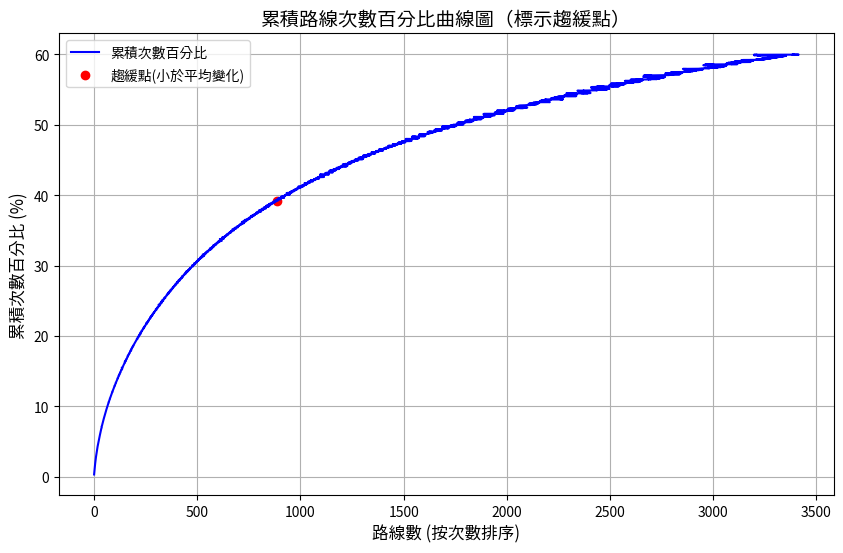

In [80]:
def get_acc(df_sorted = df_sorted):
    df_sorted['cumulative_percentage'] = (df_sorted['路線次數'].cumsum() / df_sorted['路線次數'].sum())*100

    df_filtered = df_sorted[df_sorted['cumulative_percentage'] <= 60]
    print(f"累積前60% 路線次數的平均 :{df_filtered.路線次數.mean()}")
    df_filtered

    # 3. 計算斜率，檢查每個點與前一個點的累積百分比變化
    df_filtered['slope'] = df_filtered['cumulative_percentage'].diff().fillna(0)

    # 4. 找到斜率變化較小的點，即曲線趨緩的點
    # 假設我們把斜率變化低於一個閾值(如: 0.5)作為趨緩點
    threshold = df_filtered.slope.mean()
    slowdown_points = df_filtered.iloc[1:,][df_filtered['slope'] < threshold].iloc[:1,]

    # 5. 繪製累積曲線圖
    plt.figure(figsize=(10, 6))
    plt.plot(df_filtered['cumulative_percentage'], marker='o', markersize=0.0001,linestyle='-', color='b', label='累積次數百分比')

    # 6. 標示趨緩的點
    plt.scatter(slowdown_points.index, slowdown_points['cumulative_percentage'], color='red', label='趨緩點(小於平均變化)')

    # 7. 添加標題和標籤
    plt.title('累積路線次數百分比曲線圖（標示趨緩點）', fontsize=14)
    plt.xlabel('路線數 (按次數排序)', fontsize=12)
    plt.ylabel('累積次數百分比 (%)', fontsize=12)

    # 8. 顯示圖例和網格
    plt.legend()
    plt.grid(True)

    # 9. 顯示圖表
    plt.show()

get_acc()

累積前60% 路線次數的平均 :8.496127354311355


C:\Users\tonyf\AppData\Local\Temp\ipykernel_22540\914236514.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['slope'] = df_filtered['cumulative_percentage'].diff().fillna(0)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_22540\914236514.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  slowdown_points = df_filtered.iloc[1:,][df_filtered['slope'] < threshold].iloc[:1,]


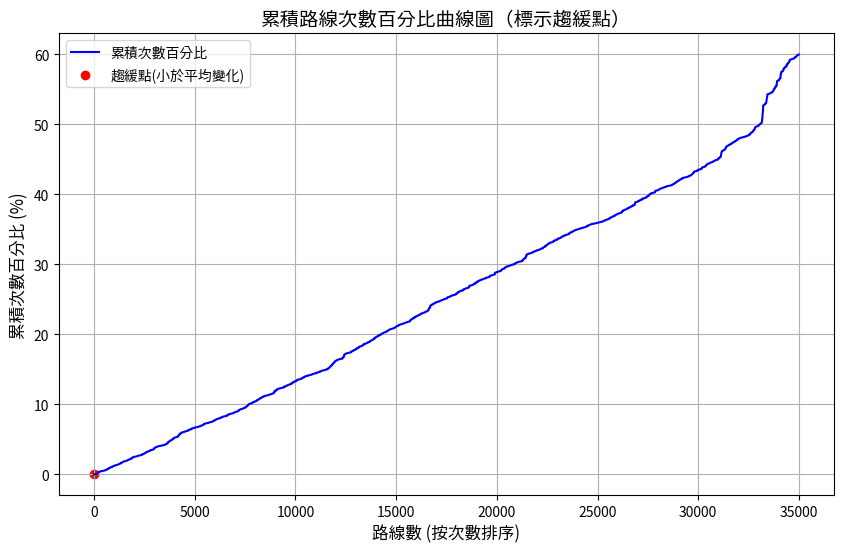

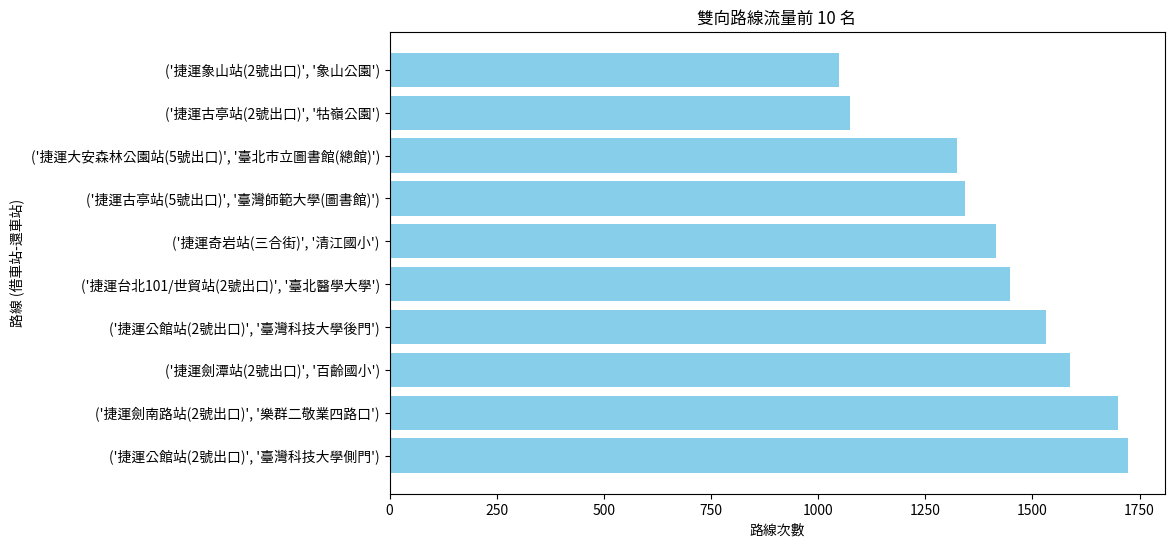

In [100]:
# 雙向路線匯總
df = df_sorted.copy()
df['route'] = df.apply(lambda row: tuple(sorted([row['借車站'], row['還車站']])), axis=1)

# 2. 根據路線進行匯總（A→B 和 B→A 視為同一路線）
df_route_summary = df.groupby('route').agg({'路線次數': 'sum', '平均時長_分': 'mean'}).reset_index()

get_acc(df_route_summary)

# 4. 繪製前 10 名流量最高的雙向路線
top_routes = df_route_summary.nlargest(10, '路線次數')

plt.figure(figsize=(10, 6))
plt.barh(top_routes['route'].astype(str), top_routes['路線次數'], color='skyblue')
plt.xlabel('路線次數')
plt.ylabel('路線 (借車站-還車站)')
plt.title('雙向路線流量前 10 名')
plt.show()

In [85]:
# 不對稱
df_asymmetric = df_sorted.copy()

# 存在不對稱流量的路線
df_asymmetric['reverse'] = df_asymmetric.apply(lambda row: df_asymmetric[(df_asymmetric['借車站'] == row['還車站']) & 
                                                                         (df_asymmetric['還車站'] == row['借車站'])]['路線次數'].sum(), axis=1)
df_asymmetric['difference'] = abs(df_asymmetric['路線次數'] - df_asymmetric['reverse'])

# 篩選出流量差異較大的路線
threshold = df_asymmetric['difference'].mean()
df_asymmetric_significant = df_asymmetric[df_asymmetric['difference'] > threshold]  # 設定一個閾值，比如 10

# 顯示結果
df_asymmetric_significant

,借車站,還車站,路線次數,reverse,difference
13,一壽橋,臺北市立景美女中,1,37,36
15,一江公園,中原公園,25,0,25
20,一江公園,仁德公園,13,0,13
46,一江公園,新生長春路口(東北側),10,0,10
58,一江公園,長春一江街口,14,2,12
...,...,...,...,...,...
71485,龍門廣場,敦化南路二段103巷口,29,2,27
71486,龍門廣場,敦化南路二段81巷,15,2,13
71487,龍門廣場,敦化基隆路口,20,9,11
71498,龍門廣場,東豐公園,11,0,11


In [92]:
df_asymmetric_significant = df_asymmetric_significant\
    .merge(sna_loc, left_on="借車站", right_on="sna")\
    .rename(columns={"lat":"lat_start","lng":"lng_start"})\
    .drop(columns="sna")\
    .merge(sna_loc, left_on="還車站", right_on="sna")\
    .rename(columns={"lat":"lat_end","lng":"lng_end"})\
    .drop(columns="sna")

In [93]:
df_asymmetric_significant.to_csv(r"D:\sandbox_git\warehouse\insight\asymmetric.csv")

In [95]:
import folium

# 創建台北市地圖
m = folium.Map(location=[25.0330, 121.5654], zoom_start=12)

# 定義顏色映射函數
def get_color(difference):
    if difference < 10:
        return 'green'  # 差異很小
    elif 10 <= difference < 50:
        return 'orange'  # 中等差異
    else:
        return 'red'  # 差異大

# 在地圖上繪製不對稱的路線
for index, row in df_asymmetric_significant.iterrows():
    start_coords = [row['lat_start'], row['lng_start']]
    end_coords = [row['lat_end'], row['lng_end']]
    
    # 根據不對稱程度選擇顏色
    color = get_color(row['difference'])
    
    # 用不同顏色繪製路線
    folium.PolyLine(locations=[start_coords, end_coords], color=color, weight=2.5, opacity=1).add_to(m)

# 將地圖保存為 HTML 文件
m.save('asymmetric_routes_map.html')

##### 見車率

In [4]:
gpd.read_file("D:\sandbox_git\warehouse\見車率_202307.geojson").query("category == '低'")

,stop_id,stop_name,capacity,latitude,longitude,category,geometry
752,U108087,東湖一號公園,10,25.07567,121.61180,低,POINT (121.6118 25.07567)
783,U108121,內湖路一段47巷,16,25.08781,121.55872,低,POINT (121.55872 25.08781)
1258,U119059,臺大共同教室北側,20,25.01595,121.53791,低,POINT (121.53791 25.01595)
1259,U119060,臺大共同教室東南側,12,25.01566,121.53786,低,POINT (121.53786 25.01566)
1264,U119065,臺大二號館,10,25.01699,121.53574,低,POINT (121.53574 25.01699)
1278,U119080,臺大小小福西南側,10,25.01539,121.53686,低,POINT (121.53686 25.01539)
1280,U119082,臺大四號館東北側,10,25.01703,121.53781,低,POINT (121.53781 25.01703)
